**Sentiment Analysis on Amazon Reviews Dataset Using Supervised Machine Learning And Neural Network**

Registration Number: 180234862

University Account: liu18wl

# Environment Preparation 

In [0]:
# Link Google Drive and Colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd ./drive/'My Drive'

/content/drive/My Drive


In [0]:
!pip install emoji

     |████████████████████████████████| 51kB 2.5MB/s 
  Created wheel for emoji: filename=emoji-0.5.3-cp36-none-any.whl size=42175 sha256=f64f20855f734556d2cf13c3d5ac9a15014d2cb79744b58b27e2a7a7527b33c0
  Stored in directory: /root/.cache/pip/wheels/86/09/26/f944015841423cd516e8a97f30e29be59e53461aea8b7d3458
Successfully built emoji


# Import packages

In [0]:
# Packages
from time import time
import re
import os
import nltk
import numpy as np
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import pickle
import string

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from emoji import demojize
from gensim.models import Word2Vec

from sklearn import naive_bayes, svm, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, confusion_matrix, roc_curve

# Settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
#tqdm.pandas(desc="Progress bar")
Tokenizer = TweetTokenizer()
cores = mp.cpu_count()

import warnings
warnings.filterwarnings('ignore')

In [0]:
def _apply_df(args):
    df, func, kwargs = args
    return df.progress_apply(func, **kwargs)

def multi_apply(df, func, **kwargs):
    workers = kwargs.pop('workers')
    pool = mp.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))

# Import dataset

In [0]:
train = pd.read_csv('train.csv', header=None)
train.tail(2)

,0,1,2
3599998,1,what is it saying?,not sure what this book is supposed to be. It ...
3599999,2,Makes My Blood Run Red-White-And-Blue,I agree that every American should read this b...


In [0]:
train[0].value_counts()

2    1800000
1    1800000
Name: 0, dtype: int64

In [0]:
test = pd.read_csv('test.csv', header=None)
test.tail(2)

,0,1,2
399998,2,Classic Jessica Mitford,This is a compilation of a wide range of Mitfo...
399999,1,"Comedy Scene, and Not Heard",This DVD will be a disappointment if you get i...


In [0]:
test[0].value_counts()

2    200000
1    200000
Name: 0, dtype: int64

In [0]:
# Merge title and content
train['Text'] = train[1]+' '+train[2]
train = train.drop(columns=[1,2])

# Negative = 0, Positive = 1
train[0] = train[0].map(lambda x: x-1)
train.rename(columns={0:'Sentiment'}, inplace=True)

In [0]:
# Merge title and content
test['Text'] = test[1]+' '+test[2]
test = test.drop(columns=[1,2])

# Negative = 0, Positive = 1
test[0] = test[0].map(lambda x: x-1)
test.rename(columns={0:'Sentiment'}, inplace=True)

In [0]:
# Merge dataset
fullset = pd.concat([train,test], axis=0, ignore_index=True)
del(train)
del(test)
fullset.to_csv('fullset.csv', index=0)

In [0]:
fullset = pd.read_csv('fullset.csv')

# Data Observation

In [0]:
fullset.tail()

,Sentiment,Text
3999995,0,Unbelievable- In a Bad Way We bought this Thom...
3999996,0,"Almost Great, Until it Broke... My son recieve..."
3999997,0,Disappointed !!! I bought this toy for my son ...
3999998,1,Classic Jessica Mitford This is a compilation ...
3999999,0,"Comedy Scene, and Not Heard This DVD will be a..."


In [0]:
fullset['Sentiment'].value_counts()

1    2000000
0    2000000
Name: Sentiment, dtype: int64

In [0]:
fullset['Text'] = fullset['Text'].apply(str)

In [0]:
fullset['Text'] = fullset['Text'].apply(Tokenizer.tokenize)

In [0]:
# The statistic of sentence length
(fullset['Text'].apply(len)).describe(percentiles=[.95, .99]).round(0)

count    4000000.0
mean          89.0
std           49.0
min            1.0
50%           79.0
95%          183.0
99%          206.0
max          314.0
Name: Text, dtype: float64

In [0]:
# Negative sentence length
(fullset[fullset.Sentiment==0]['Text'].apply(len)).describe(percentiles=[.95, .99]).round(0)

count    2000000.0
mean          93.0
std           48.0
min            1.0
50%           84.0
95%          185.0
99%          207.0
max          303.0
Name: Text, dtype: float64

In [0]:
# Positive sentence length
(fullset[fullset.Sentiment==1]['Text'].apply(len)).describe(percentiles=[.95, .99]).round(0)

count    2000000.0
mean          86.0
std           49.0
min            1.0
50%           75.0
95%          181.0
99%          206.0
max          314.0
Name: Text, dtype: float64

# Data Preprocessing

In [0]:
# Text lowercase + Stemming
def pre_proc(text):
    return ''.join([PorterStemmer().stem(x) for x in Tokenizer.tokenize(text.lower()) if x != ''])

In [0]:
demo = ['process','processing','processed','procession','processor','processors']
pd.DataFrame([demo,[PorterStemmer().stem(x) for x in demo]], index=["Input","Output"])

,0,1,2,3,4,5
Input,process,processing,processed,procession,processor,processors
Output,process,process,process,process,processor,processor


In [0]:
fullset['Token'] = multi_apply(fullset['Text'], pre_proc, workers=cores-1)

Progress bar: 100%|██████████| 571429/571429 [55:31<00:00, 171.52it/s]


In [0]:
fullset = pd.read_csv('fullset_ez_processed.csv')

In [0]:
fdist = nltk.FreqDist()

In [0]:
for i in fullset['Token']:
    for word in Tokenizer.tokenize(i):
        fdist[word] += 1

In [0]:
# Count the number of UNIQUE token
features = pd.Series(dict(fdist))
features.describe(percentiles=[.95, .99]).round(0)

count     1804633.0
mean          175.0
std         21403.0
min             1.0
50%             1.0
95%            17.0
99%           271.0
max      15792716.0
dtype: float64

In [0]:
features_1 = features[features==1]
print('There are',len(features_1),'features which only appear once.')

There are 1246917 words which only appear once.


In [0]:
print('Some once features are like this:','\''+features_1.index[1]+'\'')
print('So need to re-split them.')

Some once features are like this: 'peaceful.on'
So need to re-split them.


In [0]:
features_re = features[features<=1]

In [0]:
relist = [x for x in features_1.index if (not x.isalpha())]

In [0]:
print('There are',len(relist),'features with punctuations.')

There are 824988 features with punctuations.


In [0]:
relist_str = ''.join(relist)

In [0]:
separator = '|'.join(list(set([r'{}'.format(x) for x in relist_str if not x.isalpha()])))
print(separator,'\n')
print(demojize(separator))

🎥|̣|∂|😁|„|'||7|6|̇|~|-|😠|😔|]|≠|☆|#|😍|/|[|9|【|.|_|😩|↓|5|₤||)|⊖|👏|♠|8|💜|1|∅|℉|😡|&||␟|╚|👎|ً|🎉|$|💅|（|💖|⌫|:|😀|}|,|⟨||😎|0|=|>|╝|"|☼|%|<|♡|⊕|;|】|4|′||+|?|†||^|⊂|\|）|‼|{|!|2|😉|̄|@|*|─||♣|||(|3 

:movie_camera:|̣|∂|:beaming_face_with_smiling_eyes:|„|'||7|6|̇|~|-|:angry_face:|:pensive_face:|]|≠|☆|#|:smiling_face_with_heart-eyes:|/|[|9|【|.|_|:weary_face:|↓|5|₤||)|⊖|:clapping_hands:|:spade_suit:|8|:purple_heart:|1|∅|℉|:pouting_face:|&||␟|╚|:thumbs_down:|ً|:party_popper:|$|:nail_polish:|（|:sparkling_heart:|⌫|:|:grinning_face:|}|,|⟨||:smiling_face_with_sunglasses:|0|=|>|╝|"|☼|%|<|♡|⊕|;|】|4|′||+|?|†||^|⊂|\|）|:double_exclamation_mark:|{|!|2|:winking_face:|̄|@|*|─||:club_suit:|||(|3


In [0]:
demo = "😠,😔,😩,👏,💜,😡,👎,🎉,💖,😀,😎,😉,😍,😁,🎥".split(',')
pd.DataFrame([demo, [demojize(x) for x in demo]], index=["Emoji","Output"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Emoji,😠,😔,😩,👏,💜,😡,👎,🎉,💖,😀,😎,😉,😍,😁,🎥
Output,:angry_face:,:pensive_face:,:weary_face:,:clapping_hands:,:purple_heart:,:pouting_face:,:thumbs_down:,:party_popper:,:sparkling_heart:,:grinning_face:,:smiling_face_with_sunglasses:,:winking_face:,:smiling_face_with_heart-eyes:,:beaming_face_with_smiling_eyes:,:movie_camera:


In [0]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [0]:
def resplit(text):
    # Translate emojis
    text = demojize(text)
    # Remove punctuation
    for i in string.punctuation:
        text = text.replace(i,' ')
    # Token
    text = Tokenizer.tokenize(text)

    return text

In [0]:
fullset.Token = fullset.Token.apply(resplit)

In [0]:
fullset.tail()

,Sentiment,Token
3999995,0,"[unbeliev, in, a, bad, way, we, bought, thi, t..."
3999996,0,"[almost, great, until, it, broke, my, son, rec..."
3999997,0,"[disappoint, i, bought, thi, toy, for, my, son..."
3999998,1,"[classic, jessica, mitford, thi, is, a, compil..."
3999999,0,"[comedi, scene, and, not, heard, thi, dvd, wil..."


In [0]:
with open('fullset_resplit.pickle', 'wb') as f:
    pickle.dump(fullset, f)

In [0]:
with open('fullset_resplit.pickle', 'rb') as f:
    fullset = pickle.load(f)

In [0]:
# Re-count
fdist = nltk.FreqDist()

for i in tqdm(fullset['Token']):
    for word in i:
        fdist[word] += 1

100%|██████████| 4000000/4000000 [07:39<00:00, 8700.92it/s] 


In [0]:
fdist

FreqDist({'the': 15809493, 'i': 9294446, 'and': 8586104, 'a': 8061406, 'to': 7712911, 'it': 7578653, 'of': 6298197, 'thi': 5911844, 'is': 5530069, 'in': 3713530, ...})

In [0]:
# Count the number of UNIQUE word
features = pd.Series(dict(fdist))
features.describe(percentiles=[.95, .99]).round(0)

count      858011.0
mean          375.0
std         31793.0
min             1.0
50%             1.0
95%            51.0
99%          1065.0
max      15809493.0
dtype: float64

In [0]:
features_1 = features[features<=1]
print('There are',len(features_1),'features which appear only once.')

There are 509951 features which appear only once.


In [0]:
def rmonce(token):
    return [x for x in token if x not in features_1.index]

In [0]:
# Remove words which appear only once.
fullset.Token = fullset.Token.progress_apply(rmonce)

Progress bar: 100%|██████████| 4000000/4000000 [14:54<00:00, 4471.89it/s]   


In [0]:
# Count the length of sentences
(fullset.Token.apply(len)).describe(percentiles=[.95, .99]).round(0)

count    4000000.0
mean          80.0
std           44.0
min            0.0
50%           72.0
95%          165.0
99%          186.0
max          257.0
Name: Token, dtype: float64

In [0]:
fullset_original = pd.read_csv('fullset.csv')

In [0]:
print(fullset_original.Text[fullset.Token.apply(len)==0])

294435     ........ ............ ..... ..... ...... ........
3584048    -_- ' ' '''' '''' '' '' ''' '''''? '' '' ' '' ...
Name: Text, dtype: object


In [0]:
fullset = fullset[fullset.Token.apply(len)!=0]

In [0]:
(fullset.Token.apply(len)).describe(percentiles=[.95, .99]).round(0)

count    3999998.0
mean          80.0
std           44.0
min            1.0
50%           72.0
95%          165.0
99%          186.0
max          257.0
Name: Token, dtype: float64

In [0]:
with open('fullset_resplit_rmonce.pickle', 'wb') as f:
    pickle.dump(fullset, f, -1)

In [0]:
# The most frequent 20 words
fdist.most_common()[:20]

[('the', 15809493),
 ('i', 9294446),
 ('and', 8586104),
 ('a', 8061406),
 ('to', 7712911),
 ('it', 7578653),
 ('of', 6298197),
 ('thi', 5911844),
 ('is', 5530069),
 ('in', 3713530),
 ('for', 3524304),
 ('that', 3245780),
 ('you', 2776538),
 ('wa', 2680975),
 ('not', 2612517),
 ('book', 2498410),
 ('but', 2345642),
 ('with', 2308551),
 ('on', 2281343),
 ('have', 2190331)]

In [0]:
stopwordls = stopwords.words('english')

In [0]:
def rmstopword(token):
    return [x for x in token if x not in stopwordls]

In [0]:
# Remove stopwords
fullset.Token = fullset.Token.apply(rmstopword)

In [0]:
# Re-count
fdist = nltk.FreqDist()

for i in fullset['Token']:
    for word in i:
        fdist[word] += 1

In [0]:
# The most frequent 20 words
fdist.most_common(20)

[('thi', 5911844),
 ('wa', 2680975),
 ('book', 2498410),
 ('one', 1590682),
 ('like', 1289538),
 ('great', 1201557),
 ('veri', 1183127),
 ('good', 1167851),
 ('read', 1079779),
 ('use', 1002323),
 ('get', 995575),
 ('time', 944117),
 ('would', 939644),
 ('work', 875548),
 ('ha', 868094),
 ('movi', 773386),
 ('love', 772790),
 ('onli', 714689),
 ('hi', 665482),
 ('realli', 639812)]

In [0]:
# How many UNIQUE words
len(fdist)

810038

In [0]:
(fullset.Token.apply(len)).describe(percentiles=[.95, .99]).round(0)

count    3999998.0
mean          44.0
std           24.0
min            1.0
50%           39.0
95%           90.0
99%          102.0
max          212.0
Name: Token, dtype: float64

In [0]:
fq25, fq50, fq75, fq95, fq99 = 0, 0, 0, 0, 0
count = 0
for i in fdist_df[0]:
    fq25 += fdist.freq(i)
    fq50 += fdist.freq(i)
    fq75 += fdist.freq(i)
    fq95 += fdist.freq(i)
    fq99 += fdist.freq(i)
    count += 1
    if fq25 > 0.25:
        print('The most frequent',count, 'words have 25% portion.')
        fq25 -= 1
    if fq50 > 0.50:
        print('The most frequent',count, 'words have 50% portion.')
        fq50 -= 1
    if fq75 > 0.75:
        print('The most frequent',count, 'words have 75% portion.')
        fq75 -= 1
    if fq95 > 0.95:
        print('The most frequent',count, 'words have 95% portion.')
        fq95 -= 1
    if fq99 > 0.99:
        print('The most frequent',count, 'words have 99% portion.')
        fq99 -= 1
        

The most frequent 55 words have 25% portion.
The most frequent 294 words have 50% portion.
The most frequent 1263 words have 75% portion.
The most frequent 10323 words have 95% portion.
The most frequent 68782 words have 99% portion.


In [0]:
with open('fullset_resplit_rmonce_nostopword.pickle', 'wb') as f:
    pickle.dump(fullset, f, -1)

# Feature Engineering

In [0]:
with open('fullset_resplit_rmonce_nostopword.pickle', 'rb') as f:
    fullset = pickle.load(f)

In [0]:
#fullset = pd.read_csv('fullset_resplit_rmonce_nostopword.csv')

In [0]:
fullset.Token = fullset.Token.astype('str')

In [0]:
fullset.tail()

,Sentiment,Token
3999993,0,unbeliev bad way bought thi thoma son huge tho...
3999994,0,almost great broke son reciev thi birthday gif...
3999995,0,disappoint bought thi toy son love thoma toy n...
3999996,1,classic jessica mitford thi compil wide rang m...
3999997,0,comedi scene heard thi dvd disappoint get hope...


In [0]:
train_x, test_x, train_y, test_y = train_test_split(fullset['Token'], fullset['Sentiment'], train_size=0.9, random_state=1, stratify=fullset.Sentiment)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score

## Feature Selection

In [0]:
# The number of unique tokens is 810038
n_features = range(2500, 810000+1, 2500) # the first model has 2500 feature, then 5000, 7500, etc

for p in n_features:
    t0 = time()
    count_vect_1n = CountVectorizer(analyzer='word', ngram_range=(1,1), token_pattern=r'\w{1,}', max_features=p)
    count_vect_1n.fit(train_x)
    xtrain_count_1n = count_vect_1n.transform(train_x)
    scores = cross_val_score(naive_bayes.BernoulliNB(), xtrain_count_1n, train_y, cv=5, scoring = 'accuracy') # 5-fold CV
    err = 1-np.mean(scores)
    cv_errors.append(err)
    print('No. of features:',p,'\nCV_Errors:',err,'\nTime Spent:',time()-t0,'s\n')

No. of features: 2500 
CV_Errors: 0.17030885595052647 
Time Spent: 283.6146569252014 s

No. of features: 5000 
CV_Errors: 0.16312853901398916 
Time Spent: 279.6129081249237 s

No. of features: 7500 
CV_Errors: 0.160954162665352 
Time Spent: 309.25693106651306 s

No. of features: 10000 
CV_Errors: 0.1596922868723809 
Time Spent: 279.31574988365173 s

No. of features: 12500 
CV_Errors: 0.15915791151691105 
Time Spent: 296.594779253006 s

No. of features: 15000 
CV_Errors: 0.1588560363899575 
Time Spent: 287.0884139537811 s

No. of features: 17500 
CV_Errors: 0.15861103623566009 
Time Spent: 275.81238198280334 s

No. of features: 20000 
CV_Errors: 0.1584325986301911 
Time Spent: 300.6914439201355 s

No. of features: 22500 
CV_Errors: 0.1582804110520657 
Time Spent: 296.79409289360046 s

No. of features: 25000 
CV_Errors: 0.1581829109895656 
Time Spent: 300.8458857536316 s

No. of features: 27500 
CV_Errors: 0.1580897859387841 
Time Spent: 318.31997895240784 s

No. of features: 30000 
CV_E

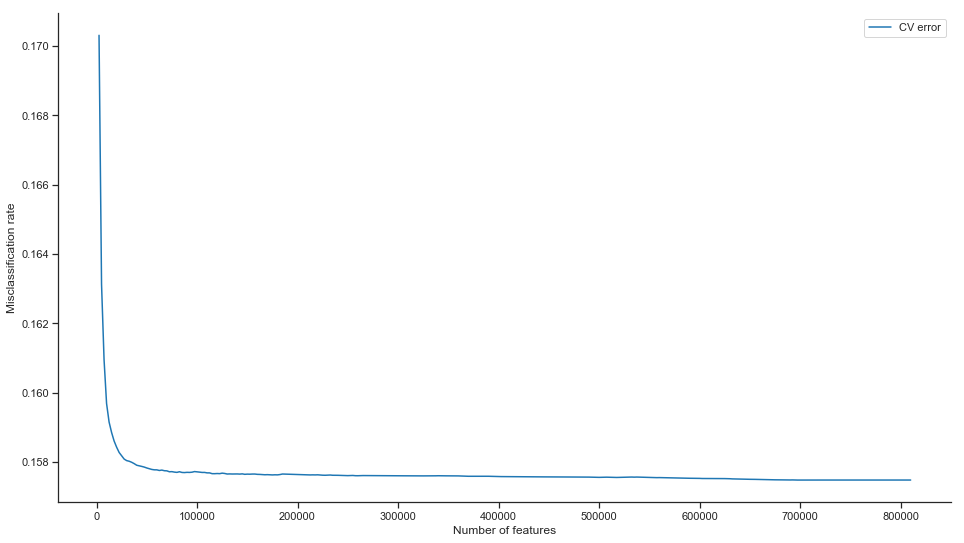

Lowest CV error: K = 697500


In [0]:
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(n_features, cv_errors, label='CV error')
ax.set_xlabel('Number of features')
ax.set_ylabel('Misclassification rate')
plt.legend()
sns.despine()
plt.show()
print('Lowest CV error: K = {}'.format(n_features[np.argmin(cv_errors)])) 

In [0]:
errors_op = pd.DataFrame()
errors_op['The Number of features'] = list(n_features)
errors_op['5-fold CV errors'] = cv_errors
errors_op.to_csv('./[ML]cv_errors.csv',index=0)

## Count Vectors + N-gram

In [0]:
t0 = time()
count_vect_1n = CountVectorizer(analyzer='word', ngram_range=(1,1), token_pattern=r'\w{1,}', max_features=697500)
count_vect_1n.fit(fullset['Token'])
print('# CV + 1-gram:', time()-t0)

# CV + 1-gram: 182.45506072044373


In [0]:
t0 = time()
count_vect_2n = CountVectorizer(analyzer='word', ngram_range=(1,2), token_pattern=r'\w{1,}', max_features=697500)
count_vect_2n.fit(fullset['Token'])
print('# CV + 2-gram:', time()-t0)

# CV + 2-gram: 941.8227388858795


In [0]:
t0 = time()
count_vect_3n = CountVectorizer(analyzer='word', ngram_range=(1,3), token_pattern=r'\w{1,}', max_features=697500)
count_vect_3n.fit(fullset['Token'])
print('# CV + 3-gram:', time()-t0)

# CV + 3-gram: 3430.9237809181213


In [0]:
# Transform the training and testing data using count vectorizer object
t0 = time()
xtrain_count_1n = count_vect_1n.transform(train_x)
xvalid_count_1n = count_vect_1n.transform(test_x)
print('# Finish CV 1n:', time()-t0)

t0 = time()
xtrain_count_2n = count_vect_2n.transform(train_x)
xvalid_count_2n = count_vect_2n.transform(test_x)
print('# Finish CV 2n:', time()-t0)

t0 = time()
xtrain_count_3n = count_vect_3n.transform(train_x)
xvalid_count_3n = count_vect_3n.transform(test_x)
print('# Finish CV 3n:', time()-t0)

# Finish CV 1n: 199.40003299713135
# Finish CV 2n: 522.5957779884338
# Finish CV 3n: 729.674252986908


In [0]:
xtrain_count_1n

<3599998x697500 sparse matrix of type '<class 'numpy.int64'>'
	with 130539171 stored elements in Compressed Sparse Row format>

In [0]:
xvalid_count_1n

<400000x697500 sparse matrix of type '<class 'numpy.int64'>'
	with 14510056 stored elements in Compressed Sparse Row format>

In [0]:
xtrain_count_2n

<3599998x697500 sparse matrix of type '<class 'numpy.int64'>'
	with 227438078 stored elements in Compressed Sparse Row format>

In [0]:
xvalid_count_2n

<400000x697500 sparse matrix of type '<class 'numpy.int64'>'
	with 25275198 stored elements in Compressed Sparse Row format>

In [0]:
xtrain_count_3n

<3599998x697500 sparse matrix of type '<class 'numpy.int64'>'
	with 241496533 stored elements in Compressed Sparse Row format>

In [0]:
xvalid_count_3n

<400000x697500 sparse matrix of type '<class 'numpy.int64'>'
	with 26837487 stored elements in Compressed Sparse Row format>

In [0]:
print(xtrain_count_3n[0])

  (0, 35540)	1
  (0, 36160)	1
  (0, 52315)	1
  (0, 53466)	1
  (0, 53483)	1
  (0, 73661)	1
  (0, 86143)	1
  (0, 87059)	1
  (0, 87389)	1
  (0, 92965)	1
  (0, 92979)	1
  (0, 94639)	1
  (0, 95754)	1
  (0, 103537)	2
  (0, 131134)	1
  (0, 131164)	1
  (0, 135003)	1
  (0, 135305)	1
  (0, 143358)	2
  (0, 145567)	2
  (0, 154138)	1
  (0, 154315)	1
  (0, 165704)	1
  (0, 214287)	1
  (0, 241274)	1
  :	:
  (0, 488233)	1
  (0, 506980)	1
  (0, 507129)	1
  (0, 520524)	1
  (0, 520540)	1
  (0, 523388)	1
  (0, 526174)	1
  (0, 527223)	1
  (0, 527976)	1
  (0, 527984)	1
  (0, 553482)	1
  (0, 567049)	1
  (0, 577511)	3
  (0, 585716)	1
  (0, 588821)	1
  (0, 589483)	1
  (0, 591623)	1
  (0, 627359)	1
  (0, 627676)	1
  (0, 644397)	3
  (0, 644437)	1
  (0, 667170)	1
  (0, 675815)	1
  (0, 679359)	1
  (0, 680208)	1


## TF-IDF Vectors + N-gram

In [0]:
t0 = time()
tfidf_vect_1n = TfidfVectorizer(analyzer='word', ngram_range=(1,1), token_pattern=r'\w{1,}', max_features=697500)
tfidf_vect_1n.fit(fullset['Token'])
print('# TF-IDF + 1-gram:', time()-t0)

# TF-IDF + 1-gram: 207.21715426445007


In [0]:
t0 = time()
tfidf_vect_2n = TfidfVectorizer(analyzer='word', ngram_range=(1,2), token_pattern=r'\w{1,}', max_features=697500)
tfidf_vect_2n.fit(fullset['Token'])
print('# TF-IDF + 2-gram:', time()-t0)

# TF-IDF + 2-gram: 1265.8044295310974


In [0]:
t0 = time()
tfidf_vect_3n = TfidfVectorizer(analyzer='word', ngram_range=(1,3), token_pattern=r'\w{1,}', max_features=697500)
tfidf_vect_3n.fit(fullset['Token'])
print('# TF-IDF + 3-gram:', time()-t0)

# TF-IDF + 3-gram: 4403.138776779175


In [0]:
t0 = time()
xtrain_tfidf_1n = tfidf_vect_1n.transform(train_x)
xvalid_tfidf_1n = tfidf_vect_1n.transform(test_x)
print('# Finish TF-IDF 1n:', time()-t0)

t0 = time()
xtrain_tfidf_2n = tfidf_vect_2n.transform(train_x)
xvalid_tfidf_2n = tfidf_vect_2n.transform(test_x)
print('# Finish TF-IDF 2n:', time()-t0)

t0 = time()
xtrain_tfidf_3n = tfidf_vect_3n.transform(train_x)
xvalid_tfidf_3n = tfidf_vect_3n.transform(test_x)
print('# Finish TF-IDF 3n:', time()-t0)

# Finish TF-IDF 1n: 224.7347650527954
# Finish TF-IDF 2n: 695.6472256183624
# Finish TF-IDF 3n: 883.1253328323364


In [0]:
xtrain_tfidf_1n

<3599998x697500 sparse matrix of type '<class 'numpy.float64'>'
	with 130539171 stored elements in Compressed Sparse Row format>

In [0]:
xvalid_tfidf_1n

<400000x697500 sparse matrix of type '<class 'numpy.float64'>'
	with 14510056 stored elements in Compressed Sparse Row format>

In [0]:
xtrain_tfidf_2n

<3599998x697500 sparse matrix of type '<class 'numpy.float64'>'
	with 227438078 stored elements in Compressed Sparse Row format>

In [0]:
xvalid_tfidf_2n

<400000x697500 sparse matrix of type '<class 'numpy.float64'>'
	with 25275198 stored elements in Compressed Sparse Row format>

In [0]:
xtrain_tfidf_3n

<3599998x697500 sparse matrix of type '<class 'numpy.float64'>'
	with 241496533 stored elements in Compressed Sparse Row format>

In [0]:
xvalid_tfidf_3n

<400000x697500 sparse matrix of type '<class 'numpy.float64'>'
	with 26837487 stored elements in Compressed Sparse Row format>

In [0]:
print(xtrain_tfidf_3n[0])

  (0, 680208)	0.07984536545073403
  (0, 679359)	0.038436269513152176
  (0, 675815)	0.05616184296126603
  (0, 667170)	0.10984981320951555
  (0, 644437)	0.16043139835477557
  (0, 644397)	0.20714506742836417
  (0, 627676)	0.12631321474693588
  (0, 627359)	0.06744762755919648
  (0, 591623)	0.10602084294749418
  (0, 589483)	0.14609745682280406
  (0, 588821)	0.049327445069430646
  (0, 585716)	0.08385064693075696
  (0, 577511)	0.05239513429333735
  (0, 567049)	0.07013099649130419
  (0, 553482)	0.09136213123883097
  (0, 527984)	0.15993171746653229
  (0, 527976)	0.10017869975424477
  (0, 527223)	0.054700597068879704
  (0, 526174)	0.07590137905177383
  (0, 523388)	0.054181830456737155
  (0, 520540)	0.16095017989210295
  (0, 520524)	0.08552730400883625
  (0, 507129)	0.15538811744352696
  (0, 506980)	0.07336955733921571
  (0, 488233)	0.06161889099259384
  :	:
  (0, 241274)	0.14276524688403255
  (0, 214287)	0.06206074808115441
  (0, 165704)	0.1329926679936413
  (0, 154315)	0.16794256881266525
  (0,

## Word2vec

In [0]:
'''
# Easy processing fullset, keep stopwords
def process_text_ez(text):
    text = str(text)
    tokenized = Tokenizer.tokenize(text)
    tokenized_lower = [word.lower() for word in tokenized]
    tokenized_stem = [PorterStemmer().stem(word) for word in tokenized_lower if word != '']
    token = ' '.join(tokenized_stem)
    return token
'''

In [0]:
'''
# Save easy processed fullset
fullset = pd.read_csv('fullset.csv')
fullset.Token = fullset.Token.apply(process_text_ez)
fullset.to_csv('fullset_ez_processed.csv', index=0)
'''

In [0]:
# Load easy processed fullset
fullset = pd.read_csv('fullset_ez_processed.csv')
fullset.Token = fullset.Token.astype('str')

In [0]:
train_vec, test_vec, train_y, test_y = train_test_split(fullset['Token'], fullset['Sentiment'], train_size=0.9, random_state=1, stratify=fullset.Sentiment)

In [0]:
# Self-trained Word2vec model
%%time

sentence = [(x.split()) for x in train_vec]
w2vmodel = Word2Vec(sentence, size=200, window=10, workers=8)

CPU times: user 1h 20min 36s, sys: 59.6 s, total: 1h 21min 35s
Wall time: 19min 31s


In [0]:
# Save trained Word2vec model
w2vmodel.wv.save_word2vec_format('w2vmodel.txt', binary=False)

In [0]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

In [0]:
# Load Twitter 200d w2v model
t0 = time()

w2vmodel = KeyedVectors.load_word2vec_format("./w2v.twitter.27B.200d.txt")
w2i = {w: i for i, w in enumerate(w2vmodel.wv.index2word)}
vectors = w2vmodel.wv.vectors

train_vec = [[w2i[w] for w in x.split() if w in w2i] for x in train_vec]
test_vec = [[w2i[w] for w in x.split() if w in w2i] for x in test_vec]
train_y = [y for y, x in zip(train_y, train_vec) if x]
test_y = [y for y, x in zip(test_y, test_vec) if x]
train_vec = [x for x in train_vec if x]
test_vec = [x for x in test_vec if x]
train_vec = [[vectors[i] for i in x] for x in train_vec]
test_vec = [[vectors[i] for i in x] for x in test_vec]
train_vec = [np.mean(x, axis=0) for x in train_vec]
test_vec = [np.mean(x, axis=0) for x in test_vec]

print("Train:",np.array(train_vec).shape)
print("Train elements:",np.array(train_vec).size)
print("Test:",np.array(test_vec).shape)
print("Test elements:",np.array(test_vec).size)

print('# [Twitter 200d Word2vec] Time Spent:', time()-t0)

Train: (3599992, 200)
Train elements: 719998400
Test: (399999, 200)
Test elements: 79999800
# [Twitter 200d Word2vec] Time Spent: 829.5483853816986


In [0]:
# Load self-trained Word2vec model
t0 = time()

w2vmodel = KeyedVectors.load_word2vec_format("./w2vmodel.txt")
w2i = {w: i for i, w in enumerate(w2vmodel.wv.index2word)}
vectors = w2vmodel.wv.vectors

train_vec = [[w2i[w] for w in x.split() if w in w2i] for x in train_vec]
test_vec = [[w2i[w] for w in x.split() if w in w2i] for x in test_vec]
train_y = [y for y, x in zip(train_y, train_vec) if x]
test_y = [y for y, x in zip(test_y, test_vec) if x]
train_vec = [x for x in train_vec if x]
test_vec = [x for x in test_vec if x]
train_vec = [[vectors[i] for i in x] for x in train_vec]
test_vec = [[vectors[i] for i in x] for x in test_vec]
train_vec = [np.mean(x, axis=0) for x in train_vec]
test_vec = [np.mean(x, axis=0) for x in test_vec]

print("Train:",np.array(train_vec).shape)
print("Train elements:",np.array(train_vec).size)
print("Test:",np.array(test_vec).shape)
print("Test elements:",np.array(test_vec).size)

print('# [Self-Word2vec] Time Spent:', time()-t0)

Train: (3599992, 200)
Train elements: 719998400
Test: (399999, 200)
Test elements: 79999800
# [Self-Word2vec] Time Spent: 717.0439891815186


# Traditional ML

In [0]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_not_svm=True):
    # fit the training dataset on the classifier
    trm = classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = trm.predict(feature_vector_valid)
    
    # Here is wrong, the predictions and real label are reversed.
    # In the dissertation, the results are corrected.
    print(confusion_matrix(predictions,test_y))
    print('Accuracy:', accuracy_score(predictions, test_y).round(4))
    print('Precision:', precision_score(predictions, test_y).round(4))
    print('Recall:', recall_score(predictions, test_y).round(4))
    print('F1 Score:', f1_score(predictions, test_y).round(4))
    '''
    confusion = confusion_matrix(predictions, test_y)
    fig, ax = plt.subplots(figsize=(8,6))
    plot_confusion_matrix(confusion, classes=['negative','positive'], normalize=True)
    plt.show()
    '''
    #print('AUC:', roc_auc_score(test_y, prob[:,1]).round(4),'\n')
    if is_not_svm:
        prob = trm.predict_proba(feature_vector_valid)
        fpr, tpr, _ = roc_curve(test_y, prob[:,1])
        auc = roc_auc_score(test_y, prob[:,1])

        fig, ax= plt.subplots(figsize=(8,6))
        ax.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(auc))
        ax.set_xlabel('False positive rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC curve', fontsize=14)
        sns.despine()
        plt.legend()
        plt.show()

## Naive Bayes

[[167363  30126]
 [ 32637 169874]]
Accuracy: 0.8431
Precision: 0.8494
Recall: 0.8388
F1 Score: 0.8441


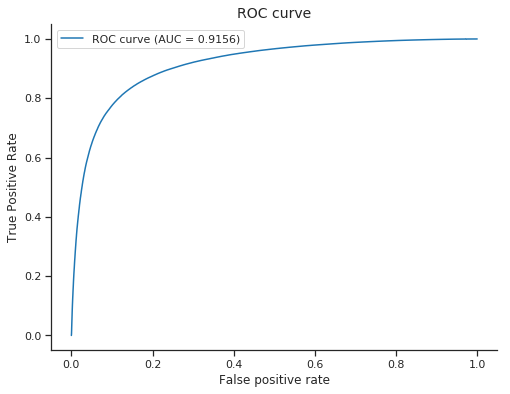

# Naive Bayes + Count Vectors + 1-gram: 7.891452074050903 

[[172795  21064]
 [ 27205 178936]]
Accuracy: 0.8793
Precision: 0.8947
Recall: 0.868
F1 Score: 0.8812


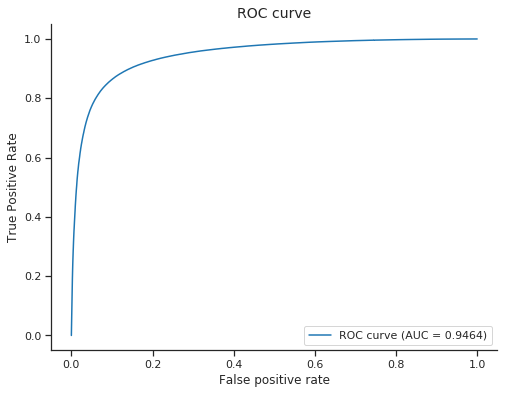

# Naive Bayes + Count Vectors + 2-gram 14.472683191299438 

[[173520  18855]
 [ 26480 181145]]
Accuracy: 0.8867
Precision: 0.9057
Recall: 0.8725
F1 Score: 0.8888


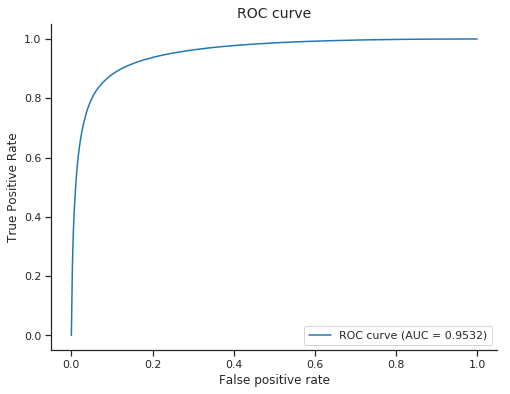

# Naive Bayes + Count Vectors + 3-gram 14.70292592048645 



In [0]:
t0 = time()
train_model(naive_bayes.BernoulliNB(), xtrain_count_1n, train_y, xvalid_count_1n)
print("# Naive Bayes + Count Vectors + 1-gram:", time()-t0, '\n')

t0 = time()
train_model(naive_bayes.BernoulliNB(), xtrain_count_2n, train_y, xvalid_count_2n)
print("# Naive Bayes + Count Vectors + 2-gram", time()-t0, '\n')

t0 = time()
train_model(naive_bayes.BernoulliNB(), xtrain_count_3n, train_y, xvalid_count_3n)
print("# Naive Bayes + Count Vectors + 3-gram", time()-t0, '\n')

[[167363  30126]
 [ 32637 169874]]
Accuracy: 0.8431
Precision: 0.8494
Recall: 0.8388
F1 Score: 0.8441


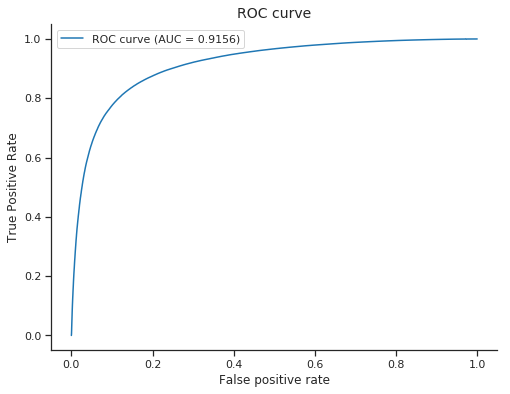

# Naive Bayes + TF-IDF + 1-gram 7.021415948867798 

[[172795  21064]
 [ 27205 178936]]
Accuracy: 0.8793
Precision: 0.8947
Recall: 0.868
F1 Score: 0.8812


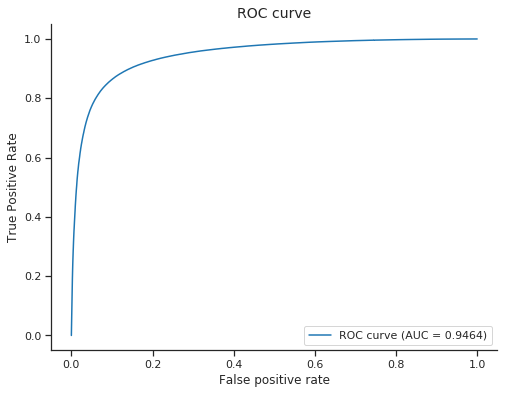

# Naive Bayes + TF-IDF + 2-gram 12.123878717422485 

[[173520  18855]
 [ 26480 181145]]
Accuracy: 0.8867
Precision: 0.9057
Recall: 0.8725
F1 Score: 0.8888


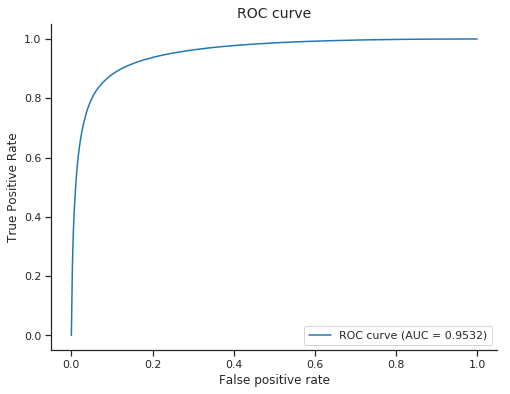

# Naive Bayes + TF-IDF + 3-gram 13.465642213821411 



In [0]:
t0 = time()
train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_1n, train_y, xvalid_tfidf_1n)
print("# Naive Bayes + TF-IDF + 1-gram", time()-t0, '\n')

t0 = time()
train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_2n, train_y, xvalid_tfidf_2n)
print("# Naive Bayes + TF-IDF + 2-gram", time()-t0, '\n')

t0 = time()
train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n)
print("# Naive Bayes + TF-IDF + 3-gram", time()-t0, '\n')

[[144780 68336]
 [55220 131664]]
Accuracy: 0.6911
Precision: 0.6583
Recall: 0.7045
F1 Score: 0.6806


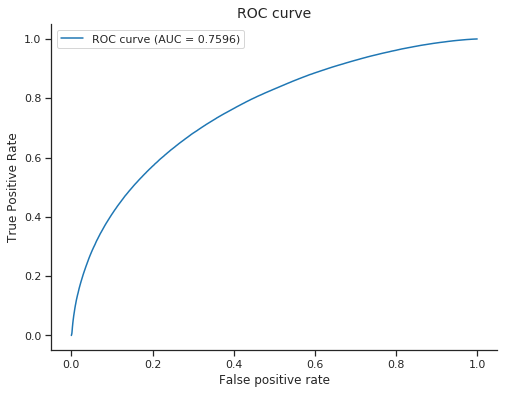

# Naive Bayes + Twitter Word2vec 27.372788667678833 



In [0]:
# Twitter 200d w2v model
t0 = time()
train_model(naive_bayes.BernoulliNB(), train_vec, train_y, test_vec)
print("# Naive Bayes + Twitter Word2vec", time()-t0, '\n')

[[148498 67790]
 [51502 132210]]
Accuracy: 0.7018
Precision: 0.6611
Recall: 0.7197
F1 Score: 0.6891


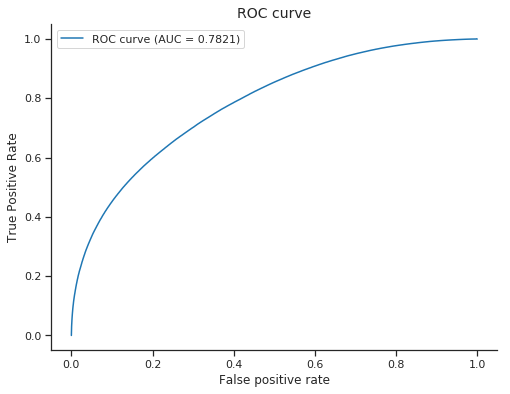

# Naive Bayes + Self-trained Word2vec 27.88288927078247 



In [0]:
# Self-trained w2v model
t0 = time()
train_model(naive_bayes.BernoulliNB(), train_vec, train_y, test_vec)
print("# Naive Bayes + Self-trained Word2vec", time()-t0, '\n')

## SVM

In [0]:
t0 = time()
train_model(svm.LinearSVC(), xtrain_count_1n, train_y, xvalid_count_1n, is_not_svm=False)
print("# SVM + Count Vectors + 1-gram", time()-t0, '\n')

t0 = time()
train_model(svm.LinearSVC(), xtrain_count_2n, train_y, xvalid_count_2n, is_not_svm=False)
print("# SVM + Count Vectors + 2-gram", time()-t0, '\n')

t0 = time()
train_model(svm.LinearSVC(), xtrain_count_3n, train_y, xvalid_count_3n, is_not_svm=False)
print("# SVM + Count Vectors + 3-gram", time()-t0, '\n')

[[175660  22092]
 [ 24340 177908]]
Accuracy: 0.8839
Precision: 0.8895
Recall: 0.8797
F1 Score: 0.8846
# SVM + Count Vectors + 1-gram 2507.6089239120483 

[[177618  22338]
 [ 22382 177662]]
Accuracy: 0.8882
Precision: 0.8883
Recall: 0.8881
F1 Score: 0.8882
# SVM + Count Vectors + 2-gram 1485.2216510772705 

[[178161  21509]
 [ 21839 178491]]
Accuracy: 0.8916
Precision: 0.8925
Recall: 0.891
F1 Score: 0.8917
# SVM + Count Vectors + 3-gram 1438.916951417923 



In [0]:
t0 = time()
train_model(svm.LinearSVC(), xtrain_tfidf_1n, train_y, xvalid_tfidf_1n, is_not_svm=False)
print("# SVM + TF-IDF + 1-gram", time()-t0, '\n')

t0 = time()
train_model(svm.LinearSVC(), xtrain_tfidf_2n, train_y, xvalid_tfidf_2n, is_not_svm=False)
print("# SVM + TF-IDF + 2-gram", time()-t0, '\n')

t0 = time()
train_model(svm.LinearSVC(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n, is_not_svm=False)
print("# SVM + TF-IDF + 3-gram", time()-t0, '\n')

[[177690  21326]
 [ 22310 178674]]
Accuracy: 0.8909
Precision: 0.8934
Recall: 0.889
F1 Score: 0.8912
# SVM + TF-IDF + 1-gram 139.35156893730164 

[[183922  15722]
 [ 16078 184278]]
Accuracy: 0.9205
Precision: 0.9214
Recall: 0.9198
F1 Score: 0.9206
# SVM + TF-IDF + 2-gram 130.5551130771637 

[[184365  15136]
 [ 15635 184864]]
Accuracy: 0.9231
Precision: 0.9243
Recall: 0.922
F1 Score: 0.9232
# SVM + TF-IDF + 3-gram 129.41166710853577 



In [0]:
# Twitter 200d w2v model
t0 = time()
train_model(svm.LinearSVC(), train_vec, train_y, test_vec, is_not_svm=False)
print("# SVM + Twitter Word2vec", time()-t0)

[[163309  41018]
 [ 36691 158982]]
Accuracy: 0.8057
Precision: 0.7949
Recall: 0.8125
F1 Score: 0.8036
# SVM + Twitter Word2vec 4995.702150583267


In [0]:
# Self-trained w2v model
t0 = time()
train_model(svm.LinearSVC(), train_vec, train_y, test_vec, is_not_svm=False)
print("# SVM + Self-trained Word2vec", time()-t0)

[[177258  24018]
 [ 22742 175982]]
Accuracy: 0.8831
Precision: 0.8799
Recall: 0.8856
F1 Score: 0.8827
# SVM + Self-trained Word2vec 4406.1866846084595


## Logistic Regression

[[177075  20810]
 [ 22925 179190]]
Accuracy: 0.8907
Precision: 0.8960
Recall: 0.8866
F1 Score: 0.8912


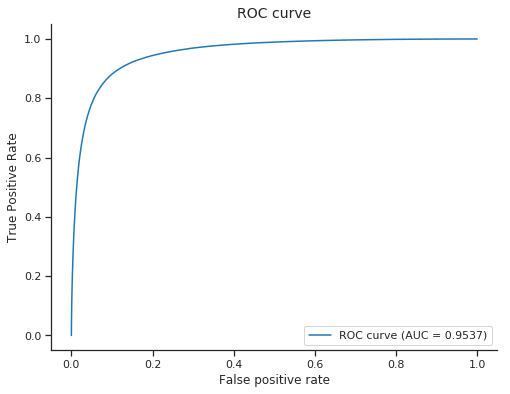

Logistic Regression + Count Vectors + 1-gram 8342.111926317215 

[[182809  16276]
 [ 17191 183724]]
Accuracy: 0.9163
Precision: 0.9186
Recall: 0.9144
F1 Score: 0.9165


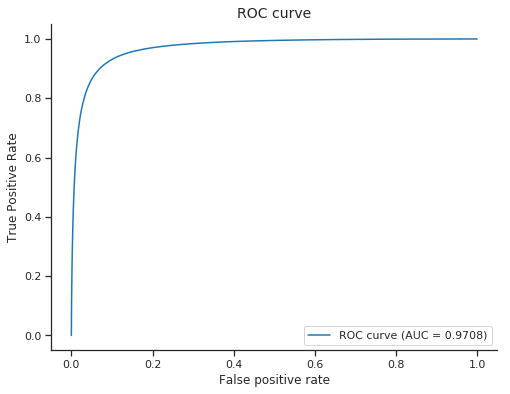


Logistic Regression + Count Vectors + 2-gram 9741.758219718933 

[[183099  16012]
 [ 16901 183988]]
Accuracy: 0.9177
Precision: 0.9199
Recall: 0.9159
F1 Score: 0.9179


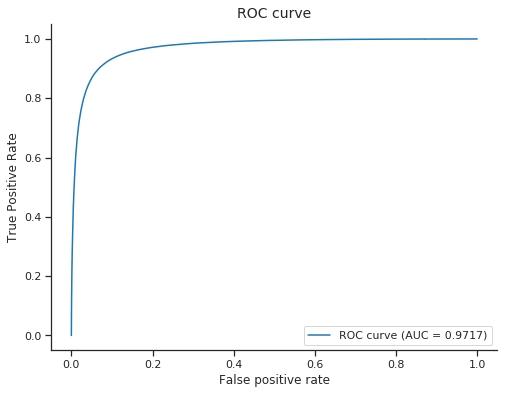


Logistic Regression + Count Vectors + 3-gram 12231.01542043686 



In [0]:
t0 = time()
train_model(linear_model.LogisticRegression(), xtrain_count_1n, train_y, xvalid_count_1n)
print("Logistic Regression + Count Vectors + 1-gram", time()-t0, '\n')

t0 = time()
train_model(linear_model.LogisticRegression(), xtrain_count_2n, train_y, xvalid_count_2n)
print("\nLogistic Regression + Count Vectors + 2-gram", time()-t0, '\n')

t0 = time()
train_model(linear_model.LogisticRegression(), xtrain_count_3n, train_y, xvalid_count_3n)
print("\nLogistic Regression + Count Vectors + 3-gram", time()-t0, '\n')

[[178074  20820]
 [ 21926 179180]]
Accuracy: 0.8931
Precision: 0.8959
Recall: 0.891
F1 Score: 0.8934


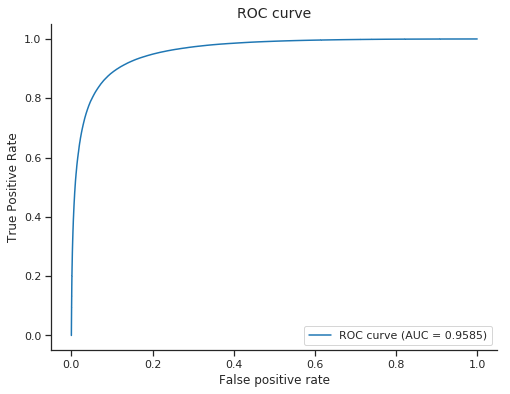

Logistic Regression + TF-IDF + 1-gram 432.92121481895447 

[[184341  15011]
 [ 15659 184989]]
Accuracy: 0.9233
Precision: 0.9249
Recall: 0.922
F1 Score: 0.9234


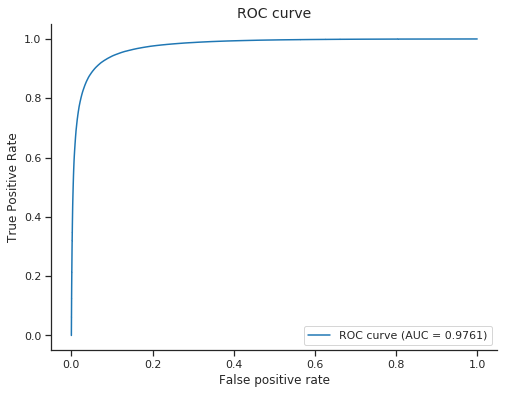


Logistic Regression + TF-IDF + 2-gram 830.950142621994 

[[184665  14647]
 [ 15335 185353]]
Accuracy: 0.925
Precision: 0.9268
Recall: 0.9236
F1 Score: 0.9252


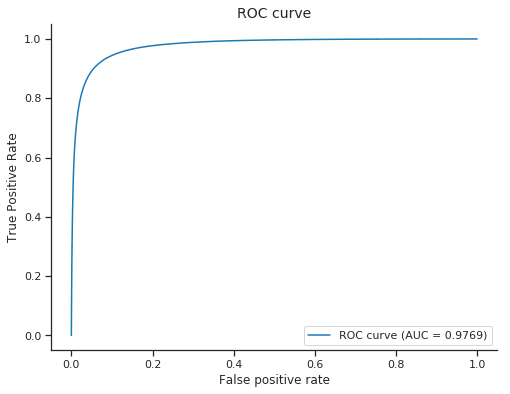


Logistic Regression + TF-IDF + 3-gram 692.5194883346558 



In [0]:
t0 = time()
train_model(linear_model.LogisticRegression(), xtrain_tfidf_1n, train_y, xvalid_tfidf_1n)
print("Logistic Regression + TF-IDF + 1-gram", time()-t0, '\n')

t0 = time()
train_model(linear_model.LogisticRegression(), xtrain_tfidf_2n, train_y, xvalid_tfidf_2n)
print("\nLogistic Regression + TF-IDF + 2-gram", time()-t0, '\n')

t0 = time()
train_model(linear_model.LogisticRegression(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n)
print("\nLogistic Regression + TF-IDF + 3-gram", time()-t0, '\n')

[[162919  40625]
 [ 37081 159375]]
Accuracy: 0.8057
Precision: 0.7969
Recall: 0.8113
F1 Score: 0.804


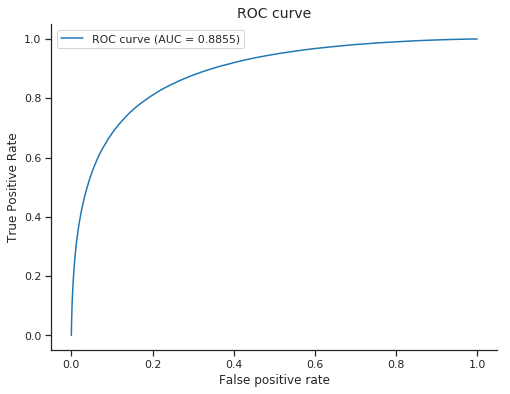

# Logistic Regression + Twitter Word2vec 505.8234417438507


In [0]:
# Twitter 200d w2v model
t0 = time()
train_model(linear_model.LogisticRegression(), train_vec, train_y, test_vec)
print("# Logistic Regression + Twitter Word2vec", time()-t0)

[[177126  23864]
 [ 22874 176136]]
Accuracy: 0.8832
Precision: 0.8807
Recall: 0.8851
F1 Score: 0.8829


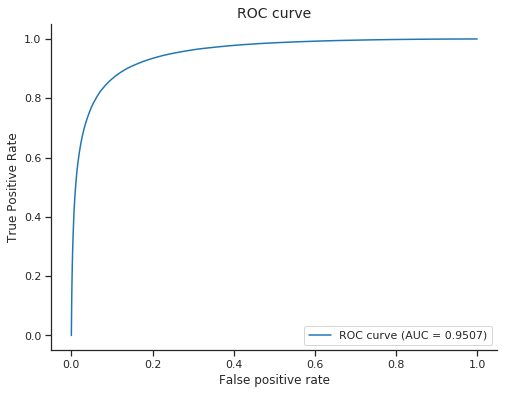

# Logistic Regression + Self-trained Word2vec 1119.5579853057861


In [0]:
# Self-trained w2v model
t0 = time()
train_model(linear_model.LogisticRegression(), train_vec, train_y, test_vec)
print("# Logistic Regression + Self-trained Word2vec", time()-t0)

# Neural Network

In [0]:
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from sklearn import metrics

Using TensorFlow backend.


In [0]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9470380119043784758
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13835863730082565624
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12356826223853656354
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14912199066
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1534016010784551440
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:
fullset = pd.read_csv('fullset_ez_processed.csv')
fullset.Token = fullset.Token.astype('str')

In [0]:
MAX_SEQUENCE_LENGTH = 256    
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.9
TEST_SPLIT = 0.9

In [0]:
# One-hot
t0 = time()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(fullset['Token'])
sequences = tokenizer.texts_to_sequences(fullset['Token'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(fullset['Sentiment']))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=TEST_SPLIT, random_state=1, stratify=fullset.Sentiment)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=VALIDATION_SPLIT, random_state=1, stratify=y_train)

print('Train rows:', len(x_train))
print('Valid rows:', len(x_val))
print('Test rows:', len(x_test))

print('Time Spent:', time()-t0, 's')

Found 926452 unique tokens.
Shape of data tensor: (4000000, 256)
Shape of label tensor: (4000000, 2)
Train rows: 3240000
Valid rows: 360000
Test rows: 400000
Time Spent: 397.6943747997284 s


In [0]:
print(sum(y_train))
print(sum(y_val))
print(sum(y_test))

[1620000. 1620000.]
[180000. 180000.]
[200000. 200000.]


In [0]:
del(fullset)
del(data)
del(labels)

In [0]:
# Parameter Selection

from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential

cnn = Sequential()
cnn.add(Embedding(len(word_index)+1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
cnn.add(Conv1D(256, 3, padding='valid', activation='elu', strides=1))
cnn.add(MaxPooling1D(3))
# cnn.add(Dropout(0.2))
cnn.add(Flatten())
# cnn.add(Dense(EMBEDDING_DIM, activation='elu'))    # Rapid convergence
cnn.add(Dense(2, activation='sigmoid'))              # Polarity classification
cnn.summary()

cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=512)

W0811 09:24:04.512081 140402165020544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 09:24:04.522568 140402165020544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 09:24:04.576113 140402165020544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0811 09:24:04.604081 140402165020544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0811 09:24:04.623397 140402165020544 deprecation_wrapper.py:119] From /us

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 200)          185290600 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 254, 256)          153856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 84, 256)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21504)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 43010     
Total params: 185,487,466
Trainable params: 185,487,466
Non-trainable params: 0
_________________________________________________________________


W0811 09:24:04.856433 140402165020544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 3240000 samples, validate on 360000 samples
Epoch 1/10
3240000/3240000 [==============================] - 1144s 353us/step - loss: 0.2094 - acc: 0.9199 - val_loss: 0.2099 - val_acc: 0.9267
Epoch 2/10
3240000/3240000 [==============================] - 1141s 352us/step - loss: 0.1484 - acc: 0.9470 - val_loss: 0.2005 - val_acc: 0.9307
Epoch 3/10
3240000/3240000 [==============================] - 1133s 350us/step - loss: 0.1072 - acc: 0.9629 - val_loss: 0.2062 - val_acc: 0.9297
Epoch 4/10
3240000/3240000 [==============================] - 1133s 350us/step - loss: 0.0755 - acc: 0.9745 - val_loss: 0.2449 - val_acc: 0.9271
Epoch 5/10
3240000/3240000 [==============================] - 1133s 350us/step - loss: 0.0548 - acc: 0.9819 - val_loss: 0.2958 - val_acc: 0.9241
Epoch 6/10
3240000/3240000 [==============================] - 1134s 350us/step - loss: 0.0418 - acc: 0.9863 - val_loss: 0.3902 - val_acc: 0.9136
Epoch 7/10
3240000/3240000 [==============================] - 1133s 350us/ste

In [0]:
def plot_graphs(history, string):
    fig, ax= plt.subplots(figsize=(16,5))
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

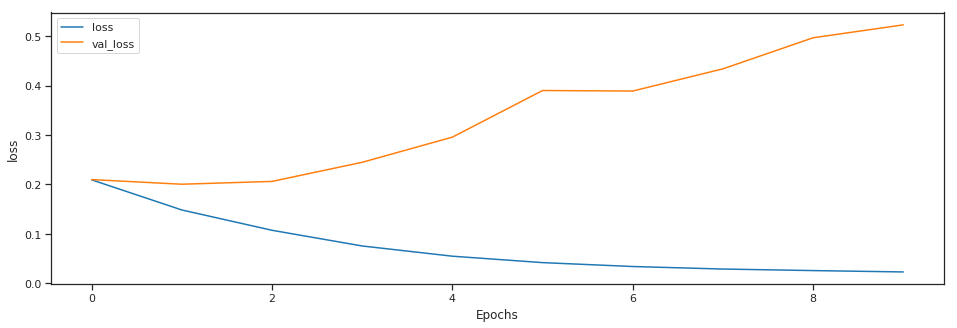

Minimum val_loss: 0.20049200122356414 Epoch: 2


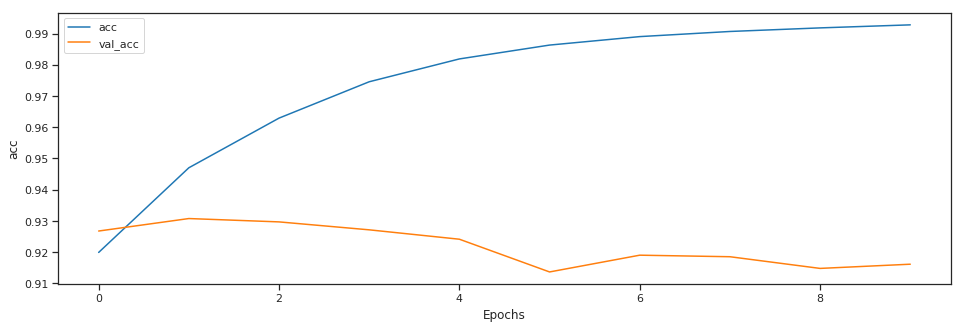

Maximum val_acc: 0.9307319444444444 Epoch: 2


In [0]:
plot_graphs(history, 'loss')
print("Minimum val_loss:",min(history.history['val_loss']),"Epoch:",history.history['val_loss'].index(min(history.history['val_loss']))+1)
plot_graphs(history, 'acc')
print("Maximum val_acc:",max(history.history['val_acc']),"Epoch:",history.history['val_acc'].index(max(history.history['val_acc']))+1)
pd.DataFrame(history.history).to_csv('./[NN]history.csv',index=0)

In [0]:
# Twitter 200d w2v model
# from keras.layers import Embedding
t0 = time()

from keras.layers import Embedding
from gensim.models import KeyedVectors

tmp_file = ("./w2v.twitter.27B.200d.txt")
w2v_model = KeyedVectors.load_word2vec_format(tmp_file)
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in tqdm(word_index.items()): 
    if str(word) in w2v_model:
        embedding_matrix[i] = np.asarray(w2v_model[str(word)],
                                         dtype='float32')
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

print('Time Spent:', time()-t0, 's')

100%|██████████| 926452/926452 [00:01<00:00, 476739.75it/s]

Time Spent: 201.3369174003601 s


In [0]:
# Self-trained Word2vec
t0 = time()

from keras.layers import Embedding
from gensim.models import KeyedVectors

tmp_file = ("./w2vmodel.txt")
w2v_model = KeyedVectors.load_word2vec_format(tmp_file)
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in tqdm(word_index.items()): 
    if str(word) in w2v_model:
        embedding_matrix[i] = np.asarray(w2v_model[str(word)],
                                         dtype='float32')
embedding_layer_self = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

print('Time Spent:', time()-t0, 's')

100%|██████████| 926452/926452 [00:01<00:00, 695094.21it/s]
W0824 09:40:02.844933 140265497880448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Time Spent: 31.181844234466553 s


## CNN

In [0]:
# CNN + One-hot
cnn_t0 = time()

from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential

cnn = Sequential()
cnn.add(Embedding(len(word_index)+1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
cnn.add(Conv1D(256, 3, padding='valid', activation='elu', strides=1))
cnn.add(MaxPooling1D(3))
# cnn.add(Dropout(0.2))
cnn.add(Flatten())
# cnn.add(Dense(EMBEDDING_DIM, activation='elu'))    # Rapid convergence
cnn.add(Dense(2, activation='sigmoid'))              # Polarity classification
cnn.summary()
plot_model(cnn, to_file="cnn1.png", show_shapes=True)

cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=512)

# Result: CNN + One-hot 
cnn_result = cnn.evaluate(x_test, y_test)
print('[Test] Loss:', cnn_result[0])
print('[Test] Accuracy:', cnn_result[1])
y_pred = cnn.predict(x_test) > 0.5
print(metrics.confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
cnn_t1 = time()-cnn_t0
print('Time Spent:', cnn_t1, 's')

W0823 11:19:03.677514 139648943888256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 11:19:03.723797 139648943888256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 11:19:03.730159 139648943888256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 11:19:03.771560 139648943888256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 200)          185290600 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 254, 256)          153856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 84, 256)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21504)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 43010     
Total params: 185,487,466
Trainable params: 185,487,466
Non-trainable params: 0
_________________________________________________________________


W0823 11:19:04.606968 139648943888256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0823 11:19:04.629416 139648943888256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0823 11:19:04.634151 139648943888256 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0823 11:19:04.850162 139648943888256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. P

Train on 3240000 samples, validate on 360000 samples
Epoch 1/2
3240000/3240000 [==============================] - 1141s 352us/step - loss: 0.2093 - acc: 0.9198 - val_loss: 0.2102 - val_acc: 0.9218
Epoch 2/2
400000/400000 [==============================] - 25s 63us/step
[Test] Loss: 0.18622809453539552
[Test] Accuracy: 0.93183125
[[189015  10985]
 [ 16329 183671]]
Time Spent: 2330.964825630188 s


In [0]:
# CNN + Word2vec
cnn_t0 = time()

from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential

cnn = Sequential()
cnn.add(embedding_layer)
cnn.add(Conv1D(256, 3, padding='valid', activation='elu', strides=1))
cnn.add(MaxPooling1D(3))
# cnn.add(Dropout(0.2))
cnn.add(Flatten())
# cnn.add(Dense(EMBEDDING_DIM, activation='elu'))    # Rapid convergence
cnn.add(Dense(2, activation='sigmoid'))              # Polarity classification
cnn.summary()
plot_model(cnn, to_file="cnn2.png", show_shapes=True)
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=512)

# Result: CNN + Word2vec
cnn_result = cnn.evaluate(x_test, y_test)
print('[Test] Loss:', cnn_result[0])
print('[Test] Accuracy:', cnn_result[1])

y_pred = cnn.predict(x_test) > 0.5
print(metrics.confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
cnn_t1 = time()-cnn_t0
print('Time Spent:', cnn_t1, 's')

W0823 14:25:29.656657 139780942600064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 14:25:29.683281 139780942600064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 14:25:29.698640 139780942600064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0823 14:25:29.699560 139780942600064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0823 14:25:35.301361 139780942600064 depre

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 200)          185290600 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 254, 256)          153856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 84, 256)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21504)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 43010     
Total params: 185,487,466
Trainable params: 185,487,466
Non-trainable params: 0
_________________________________________________________________


W0823 14:25:36.357084 139780942600064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0823 14:25:36.384647 139780942600064 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3240000 samples, validate on 360000 samples
Epoch 1/2
3240000/3240000 [==============================] - 1127s 348us/step - loss: 0.2160 - acc: 0.9174 - val_loss: 0.1806 - val_acc: 0.9336
Epoch 2/2
400000/400000 [==============================] - 27s 66us/step
[Test] Loss: 0.18906067666891962
[Test] Accuracy: 0.931125
[[181469  18531]
 [  8990 191010]]
Time Spent: 2304.701714992523 s


In [0]:
# CNN + Self-trained Word2vec
cnn_t0 = time()

from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential

cnn = Sequential()
cnn.add(embedding_layer_self)
cnn.add(Conv1D(256, 3, padding='valid', activation='elu', strides=1))
cnn.add(MaxPooling1D(3))
# cnn.add(Dropout(0.2))
cnn.add(Flatten())
# cnn.add(Dense(EMBEDDING_DIM, activation='elu'))    # Rapid convergence
cnn.add(Dense(2, activation='sigmoid'))              # Polarity classification
cnn.summary()
plot_model(cnn, to_file="cnn3.png", show_shapes=True)
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=512)

# Result: CNN + Word2vec
cnn_result = cnn.evaluate(x_test, y_test)
print('[Test] Loss:', cnn_result[0])
print('[Test] Accuracy:', cnn_result[1])

y_pred = cnn.predict(x_test) > 0.5
print(metrics.confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
cnn_t1 = time()-cnn_t0
print('Time Spent:', cnn_t1, 's')

W0823 17:21:21.351888 139632507221888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 17:21:21.365267 139632507221888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 17:21:21.374579 139632507221888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0823 17:21:21.375525 139632507221888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0823 17:21:26.086908 139632507221888 depre

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 200)          185290600 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 254, 256)          153856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 84, 256)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21504)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 43010     
Total params: 185,487,466
Trainable params: 185,487,466
Non-trainable params: 0
_________________________________________________________________


W0823 17:21:27.019447 139632507221888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0823 17:21:27.042015 139632507221888 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3240000 samples, validate on 360000 samples
Epoch 1/2
3240000/3240000 [==============================] - 1134s 350us/step - loss: 0.2286 - acc: 0.9151 - val_loss: 0.1884 - val_acc: 0.9312
Epoch 2/2
400000/400000 [==============================] - 27s 69us/step
[Test] Loss: 0.1861464353058487
[Test] Accuracy: 0.93218625
[[180741  19259]
 [  7810 192190]]
Time Spent: 2320.072587966919 s


## LSTM (RNN)

In [0]:
# LSTM + One-hot
lstm_t0 = time()

from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import CuDNNLSTM, MaxPooling1D, Embedding
from keras.models import Sequential

lstm = Sequential()
lstm.add(Embedding(len(word_index)+1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
lstm.add(CuDNNLSTM(256)) # , dropout=0.2, recurrent_dropout=0.2
# lstm.add(Dropout(0.2))
# lstm.add(Dense(EMBEDDING_DIM, activation='elu'))
lstm.add(Dense(2, activation='sigmoid'))
lstm.summary()
plot_model(lstm, to_file="lstm1.png", show_shapes=True)
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = lstm.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=512)

# Result: LSTM + One-hot
lstm_result = lstm.evaluate(x_test, y_test)
print('[Test] Loss:', lstm_result[0])
print('[Test] Accuracy:', lstm_result[1])

y_pred = lstm.predict(x_test) > 0.5
print(metrics.confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
lstm_t1 = time() - lstm_t0
print('Time Spent:', lstm_t1, 's')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 256, 200)          185290600 
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 256)               468992    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 185,760,106
Trainable params: 185,760,106
Non-trainable params: 0
_________________________________________________________________
Train on 3240000 samples, validate on 360000 samples
Epoch 1/2
3240000/3240000 [==============================] - 1794s 554us/step - loss: 0.1670 - acc: 0.9358 - val_loss: 0.1398 - val_acc: 0.9484
Epoch 2/2
400000/400000 [==============================] - 81s 204us/step
[Test] Loss: 0.1280182623276487
[Test] Accuracy: 0.9536625
[[192206   7794]
 [ 10765 189235]]
Time Spent: 3751.9600896835

In [0]:
# LSTM + Word2vec
lstm_t0 = time()

from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import CuDNNLSTM, MaxPooling1D, Embedding
from keras.models import Sequential

lstm = Sequential()
lstm.add(embedding_layer)
lstm.add(CuDNNLSTM(256)) # , dropout=0.2, recurrent_dropout=0.2
# lstm.add(Dropout(0.2))
# lstm.add(Dense(EMBEDDING_DIM, activation='elu'))
lstm.add(Dense(2, activation='sigmoid'))
lstm.summary()
plot_model(lstm, to_file="lstm2.png", show_shapes=True)
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = lstm.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=512)

# Result: LSTM + Word2vec
lstm_result = lstm.evaluate(x_test, y_test)
print('[Test] Loss:', lstm_result[0])
print('[Test] Accuracy:', lstm_result[1])

y_pred = lstm.predict(x_test) > 0.5
print(metrics.confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
lstm_t1 = time() - lstm_t0
print('Time Spent:', lstm_t1, 's')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 200)          185290600 
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 256)               468992    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 185,760,106
Trainable params: 185,760,106
Non-trainable params: 0
_________________________________________________________________
Train on 3240000 samples, validate on 360000 samples
Epoch 1/2
3240000/3240000 [==============================] - 1744s 538us/step - loss: 0.1304 - acc: 0.9521 - val_loss: 0.1274 - val_acc: 0.9531
Epoch 2/2
400000/400000 [==============================] - 79s 198us/step
[Test] Loss: 0.13970983205305412
[Test] Accuracy: 0.95093125
[[186751  13249]
 [  6315 193685]]
Time Spent: 3642.71571874

In [0]:
# LSTM + Self-trained Word2vec
lstm_t0 = time()

from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import CuDNNLSTM, MaxPooling1D, Embedding
from keras.models import Sequential

lstm = Sequential()
lstm.add(embedding_layer_self)
lstm.add(CuDNNLSTM(256)) # , dropout=0.2, recurrent_dropout=0.2
# lstm.add(Dropout(0.2))
# lstm.add(Dense(EMBEDDING_DIM, activation='elu'))
lstm.add(Dense(2, activation='sigmoid'))
lstm.summary()
plot_model(lstm, to_file="lstm3.png", show_shapes=True)
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = lstm.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=512)

# Result: LSTM + Word2vec
lstm_result = lstm.evaluate(x_test, y_test)
print('[Test] Loss:', lstm_result[0])
print('[Test] Accuracy:', lstm_result[1])

y_pred = lstm.predict(x_test) > 0.5
print(metrics.confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
lstm_t1 = time() - lstm_t0
print('Time Spent:', lstm_t1, 's')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 200)          185290600 
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 256)               468992    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 185,760,106
Trainable params: 185,760,106
Non-trainable params: 0
_________________________________________________________________
Train on 3240000 samples, validate on 360000 samples
Epoch 1/2
3240000/3240000 [==============================] - 1769s 546us/step - loss: 0.1341 - acc: 0.9503 - val_loss: 0.1274 - val_acc: 0.9533
Epoch 2/2
400000/400000 [==============================] - 81s 204us/step
[Test] Loss: 0.13407839824458584
[Test] Accuracy: 0.95257875
[[191213   8787]
 [ 10183 189817]]
Time Spent: 3695.53749513

## CNN + LSTM

In [0]:
# CNN + LSTM + One-hot
hy_t0 = time()

from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import CuDNNLSTM, Conv1D, MaxPooling1D, Embedding, TimeDistributed
from keras.models import Sequential

hybrid = Sequential()
hybrid.add(Embedding(len(word_index)+1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
hybrid.add(Conv1D(256, 3, activation='elu'))
# hybrid.add(MaxPooling1D(pool_size=3))
# hybrid.add(Dropout(0.2))
hybrid.add(CuDNNLSTM(256)) # , dropout=0.2, recurrent_dropout=0.2
# hybrid.add(Dense(EMBEDDING_DIM, activation='elu'))
hybrid.add(Dense(2, activation='sigmoid'))
hybrid.summary()
plot_model(hybrid, to_file="hybrid1.png", show_shapes=True)
hybrid.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = hybrid.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=512)

# Result: CNN + LSTM + One-hot
hy_result = hybrid.evaluate(x_test, y_test)
print('[Test] Loss:', hy_result[0])
print('[Test] Accuracy:', hy_result[1])

y_pred = hybrid.predict(x_test) > 0.5
print(metrics.confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
hy_t1 = time() - hy_t0
print('Time Spent:', hy_t1, 's')

W0824 04:33:08.066802 140095160637312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0824 04:33:08.074267 140095160637312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0824 04:33:08.084425 140095160637312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 200)          185290600 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 254, 256)          153856    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 256)               526336    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 185,971,306
Trainable params: 185,971,306
Non-trainable params: 0
_________________________________________________________________


W0824 04:33:10.562173 140095160637312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0824 04:33:10.582514 140095160637312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0824 04:33:10.586781 140095160637312 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0824 04:33:10.885964 140095160637312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. P

Train on 3240000 samples, validate on 360000 samples
Epoch 1/2
3240000/3240000 [==============================] - 2175s 671us/step - loss: 0.1609 - acc: 0.9386 - val_loss: 0.1318 - val_acc: 0.9515
Epoch 2/2
400000/400000 [==============================] - 95s 237us/step
[Test] Loss: 0.12855766020258888
[Test] Accuracy: 0.9535225
[[191138   8862]
 [  9732 190268]]
Time Spent: 4540.532166004181 s


In [0]:
# CNN + LSTM + Word2vec
hy_t0 = time()

from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import CuDNNLSTM, Conv1D, MaxPooling1D, Embedding, TimeDistributed
from keras.models import Sequential

hybrid = Sequential()
hybrid.add(embedding_layer)
hybrid.add(Conv1D(256, 3, activation='elu'))
# hybrid.add(MaxPooling1D(pool_size=3))
# hybrid.add(Dropout(0.2))
hybrid.add(CuDNNLSTM(256)) # , dropout=0.2, recurrent_dropout=0.2
# hybrid.add(Dense(EMBEDDING_DIM, activation='elu'))
hybrid.add(Dense(2, activation='sigmoid'))
hybrid.summary()
plot_model(hybrid, to_file="hybrid2.png", show_shapes=True)
hybrid.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = hybrid.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=512)

# Result: CNN + LSTM + Word2vec
hy_result = hybrid.evaluate(x_test, y_test)
print('[Test] Loss:', hy_result[0])
print('[Test] Accuracy:', hy_result[1])

y_pred = hybrid.predict(x_test) > 0.5
print(metrics.confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
hy_t1 = time() - hy_t0
print('Time Spent:', hy_t1, 's')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 256, 200)          185290600 
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 254, 256)          153856    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 256)               526336    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 185,971,306
Trainable params: 185,971,306
Non-trainable params: 0
_________________________________________________________________
Train on 3240000 samples, validate on 360000 samples
Epoch 1/2
3240000/3240000 [==============================] - 2155s 665us/step - loss: 0.1572 - acc: 0.9391 - val_loss: 0.1267 - val_acc: 0.9539
Epoch 2/2
400000/400000 [==============================] - 96s 

In [0]:
# CNN + LSTM + Self-trained Word2vec
hy_t0 = time()

from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import CuDNNLSTM, Conv1D, MaxPooling1D, Embedding, TimeDistributed
from keras.models import Sequential

hybrid = Sequential()
hybrid.add(embedding_layer_self)
hybrid.add(Conv1D(256, 3, activation='elu'))
# hybrid.add(MaxPooling1D(pool_size=3))
# hybrid.add(Dropout(0.2))
hybrid.add(CuDNNLSTM(256)) # , dropout=0.2, recurrent_dropout=0.2
# hybrid.add(Dense(EMBEDDING_DIM, activation='elu'))
hybrid.add(Dense(2, activation='sigmoid'))
hybrid.summary()
plot_model(hybrid, to_file="hybrid3.png", show_shapes=True)
hybrid.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = hybrid.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=512)

# Result: CNN + LSTM + Word2vec
hy_result = hybrid.evaluate(x_test, y_test)
print('[Test] Loss:', hy_result[0])
print('[Test] Accuracy:', hy_result[1])

y_pred = hybrid.predict(x_test) > 0.5
print(metrics.confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
hy_t1 = time() - hy_t0
print('Time Spent:', hy_t1, 's')

W0824 09:40:02.863317 140265497880448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0824 09:40:02.876609 140265497880448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0824 09:40:02.887448 140265497880448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0824 09:40:02.888115 140265497880448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 200)          185290600 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 254, 256)          153856    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 256)               526336    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 185,971,306
Trainable params: 185,971,306
Non-trainable params: 0
_________________________________________________________________


W0824 09:40:08.565198 140265497880448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0824 09:40:08.591288 140265497880448 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3240000 samples, validate on 360000 samples
Epoch 1/2
3240000/3240000 [==============================] - 2187s 675us/step - loss: 0.1445 - acc: 0.9454 - val_loss: 0.1374 - val_acc: 0.9486
Epoch 2/2
400000/400000 [==============================] - 92s 230us/step
[Test] Loss: 0.12399254189502448
[Test] Accuracy: 0.95474375
[[190651   9349]
 [  8744 191256]]
Time Spent: 4547.018759965897 s
